In [8]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [9]:
actions = [
    'come',
    'away',
    'spin'
]

data = np.concatenate([
    np.load('dataset/seq_come_1690767118.npy'),
    np.load('dataset/seq_away_1690767118.npy'),
    np.load('dataset/seq_spin_1690767118.npy')
], axis=0)

data.shape

(2509, 30, 100)

In [10]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2509, 30, 99)
(2509,)


In [11]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2509, 3)

In [12]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2258, 30, 99) (2258, 3)
(251, 30, 99) (251, 3)


In [13]:
# 넘파이 버전 확인
print(np.__version__)

1.24.2


In [14]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [15]:
import matplotlib as plt
print(plt.__version__)

3.7.1


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44163 (172.51 KB)
Trainable params: 44163 (172.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
68/71 [===========================>..] - ETA: 0s - loss: 23.3084 - acc: 0.5744
Epoch 1: val_acc improved from -inf to 0.63347, saving model to models\model.h5
71/71 [==============================] - 2s 12ms/step - loss: 22.8867 - acc: 0.5744 - val_loss: 10.8036 - val_acc: 0.6335 - lr: 0.0010
Epoch 2/200
12/71 [====>.........................] - ETA: 0s - loss: 11.9734 - acc: 0.6719

C:\Users\dxsystem\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/71 [==========================>...] - ETA: 0s - loss: 15.5797 - acc: 0.6572
Epoch 2: val_acc did not improve from 0.63347
71/71 [==============================] - 1s 9ms/step - loss: 15.4928 - acc: 0.6466 - val_loss: 16.8726 - val_acc: 0.4940 - lr: 0.0010
Epoch 3/200
68/71 [===========================>..] - ETA: 0s - loss: 231.4155 - acc: 0.5882
Epoch 3: val_acc did not improve from 0.63347
71/71 [==============================] - 1s 9ms/step - loss: 232.5394 - acc: 0.5908 - val_loss: 91.2969 - val_acc: 0.6096 - lr: 0.0010
Epoch 4/200
70/71 [============================>.] - ETA: 0s - loss: 45.7061 - acc: 0.7004
Epoch 4: val_acc did not improve from 0.63347
71/71 [==============================] - 1s 9ms/step - loss: 45.8451 - acc: 0.6988 - val_loss: 48.3518 - val_acc: 0.5299 - lr: 0.0010
Epoch 5/200
68/71 [===========================>..] - ETA: 0s - loss: 23.4818 - acc: 0.7210
Epoch 5: val_acc improved from 0.63347 to 0.86853, saving model to models\model.h5
71/71 [================

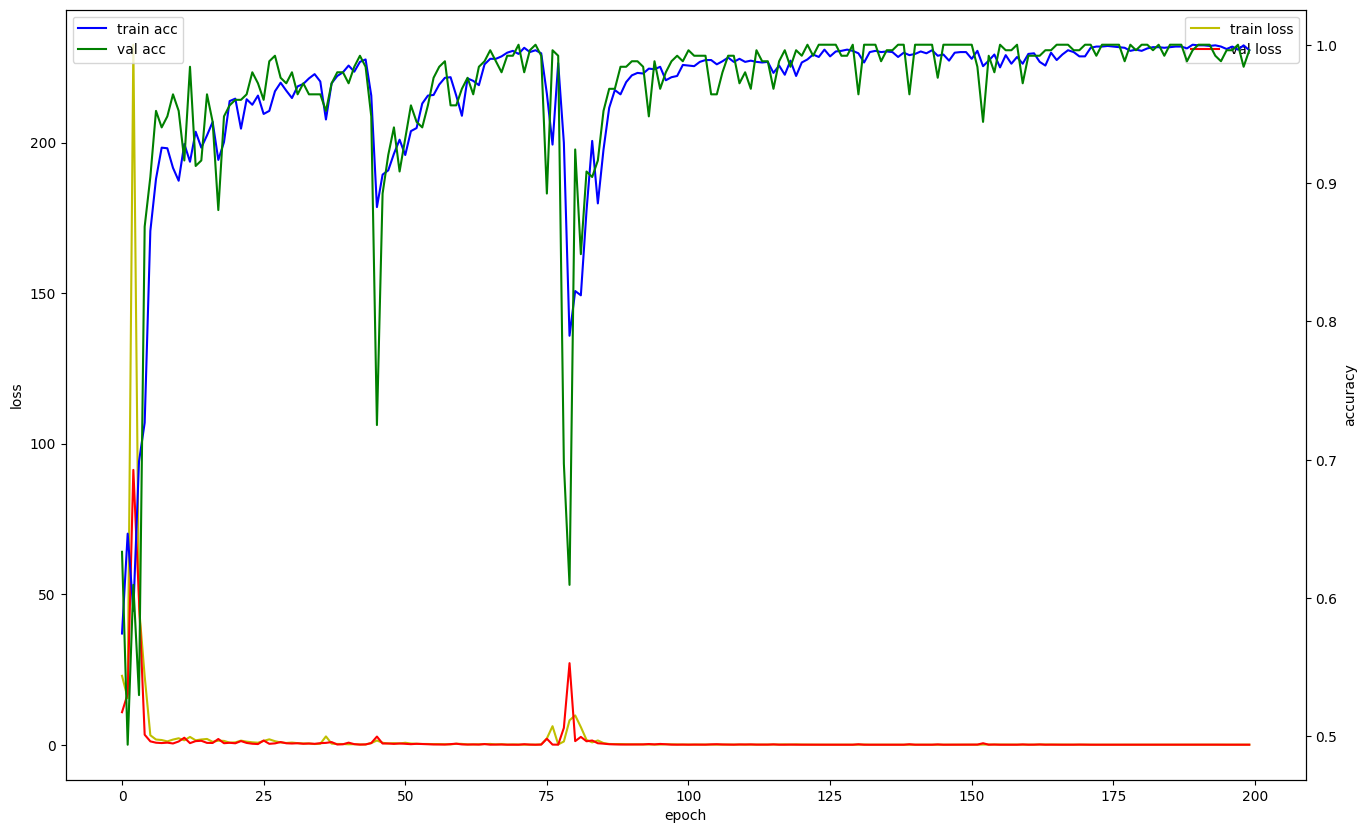

In [18]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [19]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

8/8 [==============================] - 0s 4ms/step


array([[[165,   0],
        [  0,  86]],

       [[157,   0],
        [  0,  94]],

       [[180,   0],
        [  0,  71]]], dtype=int64)